In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
from pathlib import Path

import lightning.pytorch as pl
import torch
import wandb
from sdofm import utils
from sdofm.datasets import SDOMLDataModule, DegradedSDOMLDataModule
from sdofm.pretraining import MAE, SAMAE
from sdofm.finetuning import Autocalibration

In [4]:
import omegaconf

cfg = omegaconf.OmegaConf.load("../experiments/ablation_autocalibration.yaml")

In [23]:
data_module = DegradedSDOMLDataModule(
    hmi_path=None,
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.aia
    ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=cfg.model.opt.batch_size,
    num_workers=cfg.data.num_workers,
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
    min_date=cfg.data.min_date,
    max_date=cfg.data.max_date,
    num_frames=cfg.data.num_frames,
    drop_frame_dim=cfg.data.drop_frame_dim,
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [24]:
data = next(iter(data_module.train_ds))

In [19]:
df = 1.0 * torch.rand(9)

tensor([0.5814, 0.8425, 0.2853, 0.2105, 0.6301, 0.9060, 0.1794, 0.7342, 0.5985])

In [22]:
any(torch.zeros(9) < 0)

False

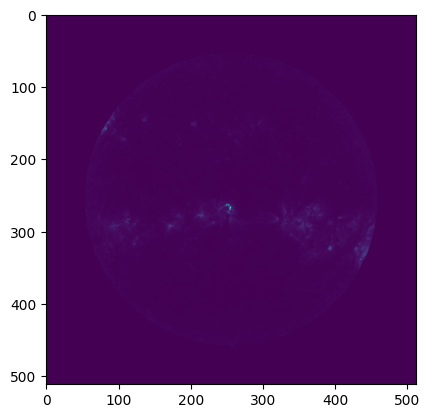

In [25]:
import matplotlib.pyplot as plt

plt.imshow(data[0][0])

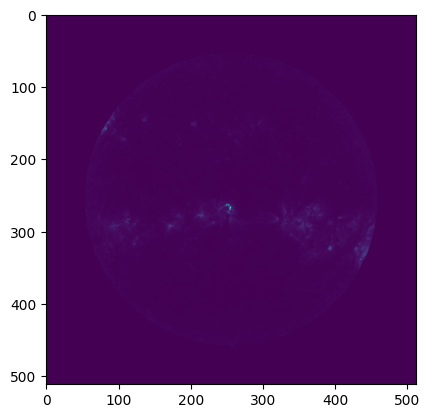

In [26]:
plt.imshow(data[2][0])

In [27]:
data[1]

tensor([0.4342, 0.9068, 0.1045, 0.1870, 0.3194, 0.8495, 0.0398, 0.9326, 0.8095])

In [5]:
data_module = DegradedSDOMLDataModule(
    hmi_path=None,
    aia_path=os.path.join(
        cfg.data.sdoml.base_directory, cfg.data.sdoml.sub_directory.aia
    ),
    eve_path=None,
    components=cfg.data.sdoml.components,
    wavelengths=cfg.data.sdoml.wavelengths,
    ions=cfg.data.sdoml.ions,
    frequency=cfg.data.sdoml.frequency,
    batch_size=cfg.model.opt.batch_size,
    num_workers=cfg.data.num_workers,
    val_months=cfg.data.month_splits.val,
    test_months=cfg.data.month_splits.test,
    holdout_months=cfg.data.month_splits.holdout,
    cache_dir=os.path.join(
        cfg.data.sdoml.base_directory,
        cfg.data.sdoml.sub_directory.cache,
    ),
    min_date=cfg.data.min_date,
    max_date=cfg.data.max_date,
    num_frames=cfg.data.num_frames,
    drop_frame_dim=cfg.data.drop_frame_dim,
)
data_module.setup()

[* CACHE SYSTEM *] Found cached index data in /mnt/sdoml/cache/aligndata_AIA_FULL_12min.csv.
[* CACHE SYSTEM *] Found cached normalization data in /mnt/sdoml/cache/normalizations_AIA_FULL_12min.json.
[* CACHE SYSTEM *] Found cached HMI mask data in /mnt/sdoml/cache/hmi_mask_512x512.npy.


In [6]:
d_unnormal = next(iter(data_module.test_ds))

In [7]:
d_normal = next(iter(data_module.train_ds))

In [18]:
import matplotlib.pyplot as plt
import numpy as np

In [14]:
len(d_unnormal[0])

9

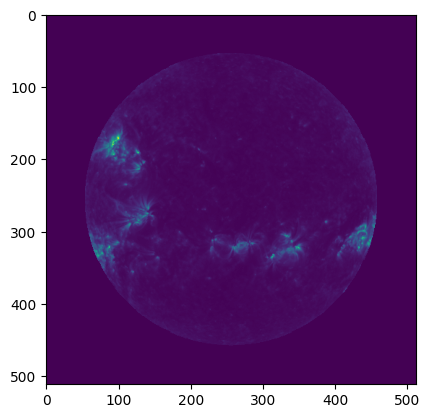

In [35]:
plt.imshow(d_unnormal[0][0, :, :])

In [26]:
torch.min(d_unnormal[0][0, :, :].reshape(-1)), torch.max(
    d_unnormal[0][0, :, :].reshape(-1)
)

(tensor(-0.4748), tensor(27.0083))

(array([2.5343e+05, 5.5070e+03, 2.0040e+03, 7.1700e+02, 2.9000e+02,
        1.1800e+02, 4.6000e+01, 2.1000e+01, 7.0000e+00, 4.0000e+00]),
 array([-0.47478777,  2.27352571,  5.02183914,  7.77015257, 10.518466  ,
        13.26677895, 16.01509285, 18.76340675, 21.51171875, 24.26003265,
        27.00834656]),
 <BarContainer object of 10 artists>)

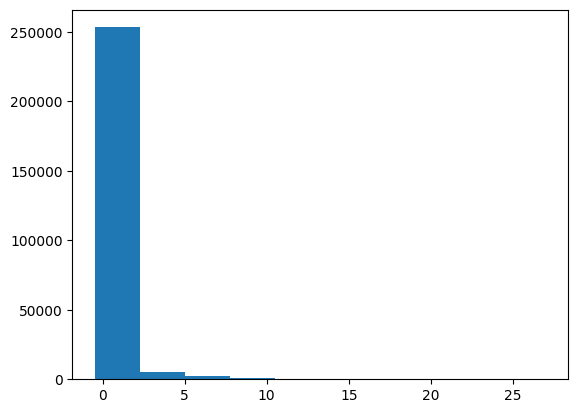

In [32]:
plt.hist(d_unnormal[0][0, :, :].reshape(-1))

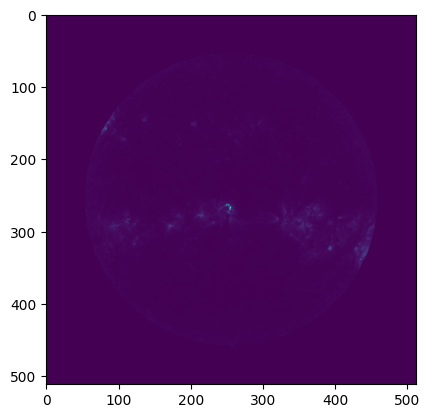

In [16]:
plt.imshow(d_normal[0][0, :, :])

In [28]:
torch.min(d_normal[0][0, :, :].reshape(-1)), torch.max(d_normal[0][0, :, :].reshape(-1))

(tensor(-0.2612), tensor(58.0028))

(array([2.61791e+05, 3.04000e+02, 2.90000e+01, 8.00000e+00, 4.00000e+00,
        2.00000e+00, 2.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([-0.26116934,  5.56522322, 11.39161587, 17.21800804, 23.04440117,
        28.8707943 , 34.69718552, 40.52357864, 46.34997177, 52.1763649 ,
        58.00275803]),
 <BarContainer object of 10 artists>)

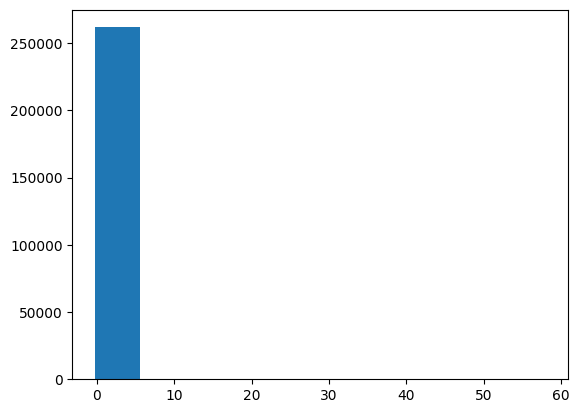

In [33]:
plt.hist(d_normal[0][0, :, :].reshape(-1))